In [2]:
!pwd

/Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/notebooks/julien-hovan


# **Week 1: EDA and Audio-to-Spectrogram Transformation**

**Goals:**

- Understand the principles of audio-to-spectrogram conversion and its relevance to genre classification.
- Experiment with STFT and Mel spectrogram generation using `librosa`, analyzing the impact of key parameters (window size, hop length, number of Mel bands).
- *Optional:* Briefly explore Constant-Q Transform (CQT).
- For those using pre-extracted 30s features from CSV: Focus on EDA of these features to understand their importance for genre classification. Use visualization and statistical analysis to identify the most discriminative features.
- Document the characteristics of each spectrogram type, parameter effects, and insights from feature analysis to inform future model development.

Importing the libraries

In [10]:
# standard imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# for interactivity
import ipywidgets as widgets
from IPython.display import display, clear_output


# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
# lets read in the data (30s features)

features_30s_df = pd.read_csv('/Users/julienh/Desktop/SDS/SDS-CP018-music-classifier/Data/features_30_sec.csv')

features_30s_df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [5]:
features_30s_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

We know that all the features are numerical.

In [6]:

audio_features = features_30s_df.columns[1:-1]
print("audio_features:\n", "\n".join(audio_features.tolist()))


audio_features:
 length
chroma_stft_mean
chroma_stft_var
rms_mean
rms_var
spectral_centroid_mean
spectral_centroid_var
spectral_bandwidth_mean
spectral_bandwidth_var
rolloff_mean
rolloff_var
zero_crossing_rate_mean
zero_crossing_rate_var
harmony_mean
harmony_var
perceptr_mean
perceptr_var
tempo
mfcc1_mean
mfcc1_var
mfcc2_mean
mfcc2_var
mfcc3_mean
mfcc3_var
mfcc4_mean
mfcc4_var
mfcc5_mean
mfcc5_var
mfcc6_mean
mfcc6_var
mfcc7_mean
mfcc7_var
mfcc8_mean
mfcc8_var
mfcc9_mean
mfcc9_var
mfcc10_mean
mfcc10_var
mfcc11_mean
mfcc11_var
mfcc12_mean
mfcc12_var
mfcc13_mean
mfcc13_var
mfcc14_mean
mfcc14_var
mfcc15_mean
mfcc15_var
mfcc16_mean
mfcc16_var
mfcc17_mean
mfcc17_var
mfcc18_mean
mfcc18_var
mfcc19_mean
mfcc19_var
mfcc20_mean
mfcc20_var


In [7]:
def describe_dataframe(df):
    """
    Explores a pandas DataFrame by separating numerical and categorical columns
    and providing descriptive statistics for numerical columns.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        tuple: A tuple containing two pandas DataFrames.
            The first DataFrame contains descriptive statistics for numerical columns.
            The second DataFrame contains the names of the non-numerical columns.
    """
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    non_numerical_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    
    print("Non-numerical columns:", non_numerical_cols)
    
    return df[numerical_cols].describe(), non_numerical_cols

numerical_description, non_numerical_columns = describe_dataframe(features_30s_df)
numerical_description

Non-numerical columns: ['filename', 'label']


,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,661794.000000,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,675808.000000,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


Because theres a lot of features, I like creating interactive plots with dropdown selectors (possibly selecting more than one feature at a time) to explore the without too many repeated lines of code.

In [20]:

def plot_feature_by_label_interactive(df, label_name='label'):
    """
    Creates an interactive dropdown to select features and plot their distribution by label.

    Args:
        df (pd.DataFrame): The input DataFrame.
        label_name (str, optional): The name of the label column. Defaults to 'label'.
    """
    features = [col for col in df.columns if col != label_name and col != 'filename']
    
    feature_dropdown = widgets.SelectMultiple(
        options=features,
        description='Features:',
        disabled=False
    )
    
    output = widgets.Output()

    def update_plot(*args):
        selected_features = feature_dropdown.value
        with output:
            clear_output(wait=True)
            if not selected_features:
                print("Please select at least one feature.")
                return
            for feature_name in selected_features:
                plt.figure(figsize=(10, 6))
                sns.barplot(x=label_name, y=feature_name, data=df)
                plt.title(f'{feature_name} by {label_name}')
                plt.xticks(rotation=45)
                plt.show()

    feature_dropdown.observe(update_plot, names='value')
    
    display(feature_dropdown, output)


In [21]:
# plot the features by label - not normalized
plot_feature_by_label_interactive(features_30s_df)

SelectMultiple(description='Features:', options=('length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', …

Output()

In [19]:
# lets normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_30s_df.drop(columns=['filename', 'label']))
normalized_df = pd.DataFrame(normalized_features, columns=X.columns)
normalized_df['label'] = features_30s_df['label']

# Plot normalized features
plot_feature_by_label_interactive(normalized_df, label_name='label')

SelectMultiple(description='Features:', options=('length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', …

Output()

## Feature Importance using Random Forest Classifier

We can use a randomforest classifier to classify the genres and look at the feature importance to get a quick understanding of the features that are most important for each genre.

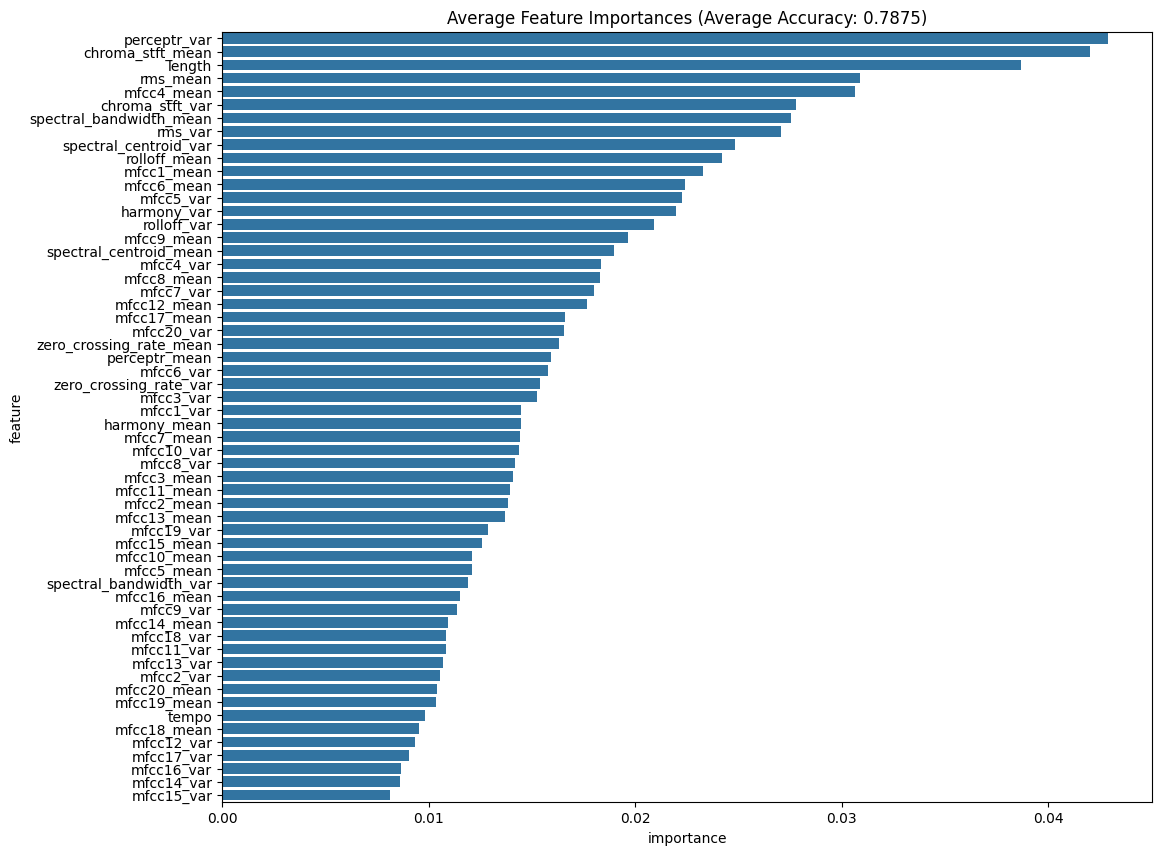

In [15]:
X = features_30s_df.drop(columns=['filename', 'label'])
y = features_30s_df['label']

num_runs = 10  # Number of times to run the RandomForest
feature_importances_list = []
accuracy_list = []

for i in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 + i) # add a seed to the random state
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    feature_importances_list.append(rf_classifier.feature_importances_)
    
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

# Average feature importances
average_feature_importances = np.mean(feature_importances_list, axis=0)
average_accuracy = np.mean(accuracy_list)

feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': average_feature_importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title(f'Average Feature Importances (Average Accuracy: {average_accuracy:.4f})')
plt.show()

We can see that the topfeatures are:

- perceptr var
- chroma_stft_mean
- length
-rms)mean
- mfcc4_mean
- chroma_sftf_var